In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import os
import matplotlib.pyplot as plt

# This is the data generated by the device: 
**Features are:**
* Voltage 
* Current 
* Active Power
* Power Factor
* Apparent Power
* Reactive Power
* Frequency
* Time Stamp


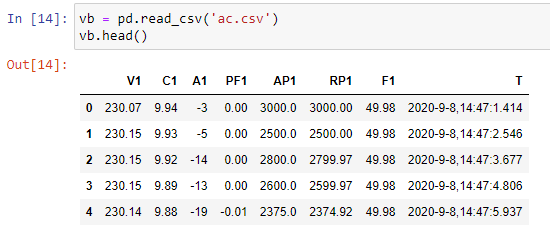

**Converted the samples into 1 minute duration signatures in the form of 7d array** 
* Displaying only 30 samples per signature instead of 60

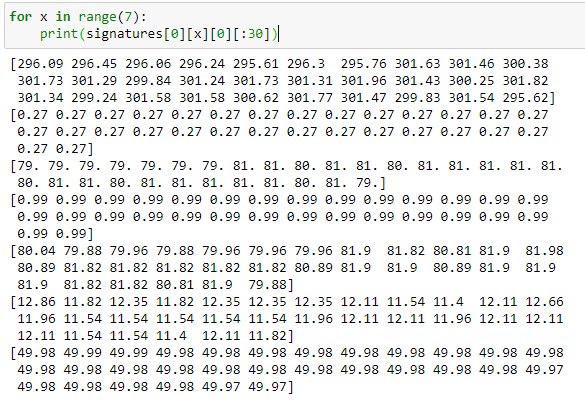

**Created multilabels for each signature**

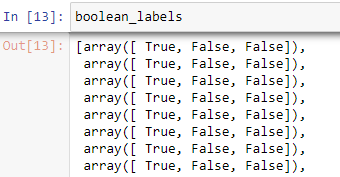

**The signatures would be like this**

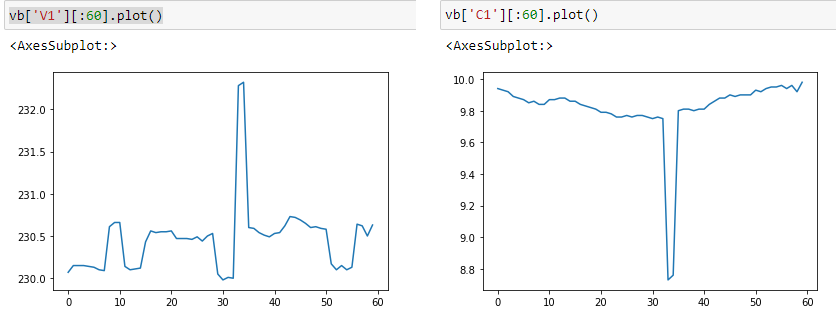

**Simmilarly converted almost 90 minutes data for each device, along with the multilabels.**
**Therefore for 

* X -> all the signatures 
* y -> the multilabels

**Used Train_test split to form train data and validation data, and converted them to tensors

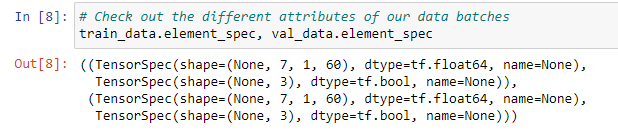

**This is how i define the model**

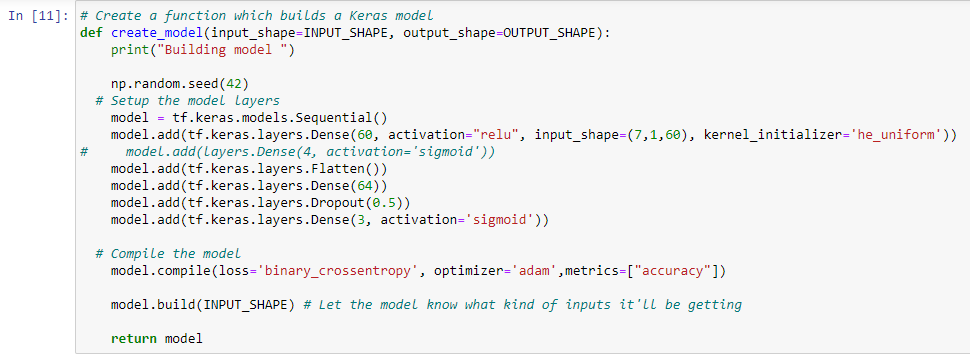

**Model Summary**

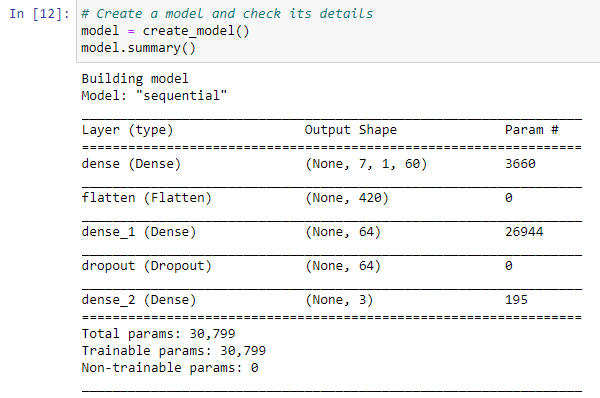

**Evalutaion**

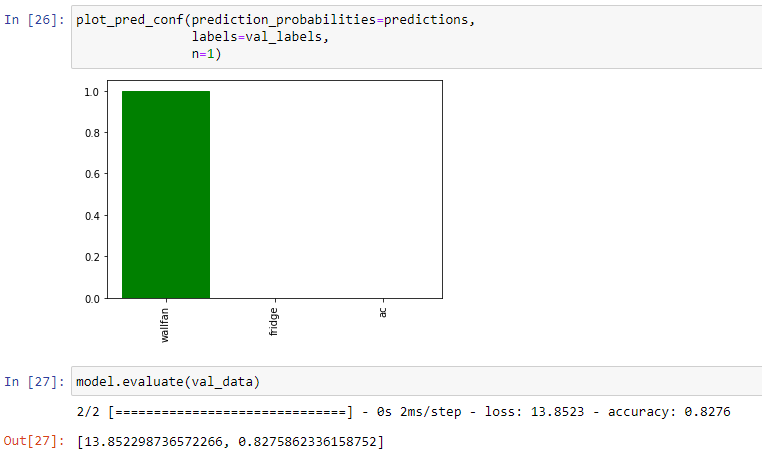

**one thing i know is that whenever a model gives a probability of 1, something is definitely wrong with it. not quite sure what exactly it is. it gives correct result for individual signatures but for a combined signature, the prediction is not right.i have doubts regarding the data representation and the model creation technique used**

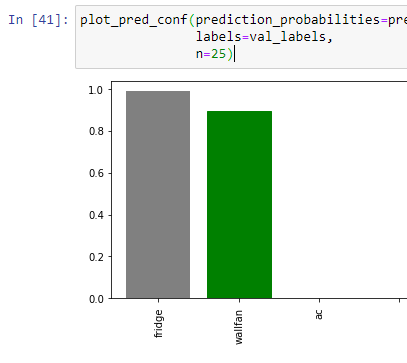

In [212]:
def get_xy(*args,test_data=False):
    """
        Takes CSV file names (without extension) having samples of device as input.
        The column names must be as : V1,C1,A1,PF1,AP1,RP1,F1,T
        Converts it to a dataset of signatures of duration 1 min.
        Exports the modified CSV in seconds frequency, and signature format in separate files as: 
            1. (filename_seconds.csv) 
            2. (filename_7d.npy).
        Returns 1. the 7-D signatures of devices, and the 2. appropriate labels in the form of numpy arrays.
    """
    devices = []
    for x in args:
        devices.append(x)
    size = 0
    files = np.array([])
    names = np.array([])

    for fn in devices:
        df = pd.read_csv(f'{fn}.csv')

        # Resampling the data in proper seconds frequency

        df['T'] = pd.DatetimeIndex(df['T'],tz = 'Asia/Kolkata')
        df = df.set_index('T')
        df = df.resample('S').mean()
        df.to_csv(f'{fn}_seconds.csv',index= False)
        df = df.dropna()
        # a signature is of length 60, thus remove incomplete signature
        samples = df.shape[0]
        extra_samples = samples%60
        samples = samples - extra_samples
        df = df[:samples]
        #labelling each row
        # Converting the samples into a signature of 1 minute. (Not sure if this is the right way of representing an energy signature)

        # Converting the feature variables into numpy arrays
        features = ['V1','C1','A1','PF1','AP1','RP1','F1']
        for feature in features:
            if feature == 'V1':
                    np_v = df[feature].to_numpy()
            elif feature =='C1':
                np_c = df[feature].to_numpy()
            elif feature =='A1':
                np_a = df[feature].to_numpy()
            elif feature =='PF1':
                np_pf = df[feature].to_numpy()
            elif feature =='AP1':
                np_ap = df[feature].to_numpy()
            elif feature =='RP1':
                np_rp = df[feature].to_numpy()
            elif feature =='F1':
                np_f = df[feature].to_numpy()
        

        #separating signatures into rows resulting into ' n ' signatures of device of length 60 seconds
        no_signatures = samples//60  # no of signatures per device collected
        np_v = np_v.reshape((no_signatures),60)  
        np_c = np_c.reshape((no_signatures),60)
        np_a = np_a.reshape((no_signatures),60)
        np_pf = np_pf.reshape((no_signatures),60)
        np_ap = np_ap.reshape((no_signatures),60)
        np_rp = np_rp.reshape((no_signatures),60)
        np_f = np_f.reshape((no_signatures),60)

        #combining all the feature variables of one signature into 7 dimensions i.e the shape of the signature will be(7,1,60) 
        #maybe should make it (7,60), havent tried that yet
        signatures = [] 
        for x in range(no_signatures):
            # signature_array will be 2 dimensional array with a length of 7 rows x 60 columns
            signature_array = np.array([
                                        np_v[x],
                                        np_c[x],
                                        np_a[x],
                                        np_pf[x],
                                        np_ap[x],
                                        np_rp[x],
                                        np_f[x]
                                      ])
            signatures.append(signature_array)
        signatures = np.asarray(signatures)
        label_series = pd.Series([fn])
        label_series = label_series.repeat(no_signatures)
        labels = label_series.to_numpy()
        names = np.append(names,labels)
        files = np.append(files,signatures)
        s = signatures.shape[0]
        size += s
    files = files.reshape((size,7,60)) 
    print(files.shape)
    if test_data ==True:
        return files
        
        
    return files,names

In [281]:
files, names = get_xy('ac','fridge','wallfan','3dprinter')

(379, 7, 60)


In [282]:
files.shape

(379, 7, 60)

In [284]:
unique_devices = np.unique(names)
# Turn every label into a boolean array
boolean_labels = [name == np.array(unique_devices) for name in names]

In [285]:
unique_devices

array(['3dprinter', 'ac', 'fridge', 'wallfan'], dtype=object)

In [286]:
len(boolean_labels)

379

In [287]:
# Setup X & y variables
X = files
y = boolean_labels

In [288]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(303, 303, 76, 76)

In [289]:
X_test = get_xy('vf',test_data=True)

(203, 7, 60)


In [290]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
      Creates batches of data out of  (x) and label (y) pairs.
      Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
      Also accepts test data as input (no labels).
    """
  # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only files
        data_batch = data.batch(BATCH_SIZE)
        return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.batch(BATCH_SIZE)
        return data_batch

    else:
        # If the data is a training dataset, we shuffle it
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                  tf.constant(y))) # labels
    
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))

        
        # Turn the data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [291]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
test_data = create_data_batches(X_test, test_data=True)

Creating training data batches...
Creating validation data batches...
Creating test data batches...


In [292]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec,test_data.element_spec

((TensorSpec(shape=(None, 7, 60), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 7, 60), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 TensorSpec(shape=(None, 7, 60), dtype=tf.float64, name=None))

In [293]:
# Setup input shape to the model
INPUT_SHAPE = [None, 7, 60] # batch, rows, columns, features

# Setup output shape of the model
OUTPUT_SHAPE = len(boolean_labels[0]) # number of unique labels

In [294]:
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score

In [295]:
INPUT_SHAPE

[None, 7, 60]

In [296]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    print("Building model ")
    
    np.random.seed(42)
  # Setup the model layers
    model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Embedding(input_dim=INPUT_SHAPE, output_dim=OUTPUT_SHAPE))
    model.add(tf.keras.layers.LSTM(60, activation='relu', input_shape=(7,60)))
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='sigmoid'))
    
#     model.add(tf.keras.layers.Dense(60, activation="relu", input_shape=(7,1,60), kernel_initializer='he_uniform'))
#     model.add(tf.keras.layers.Flatten()) 
#     model.add(tf.keras.layers.Dense(64))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='sigmoid'))

  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
    
    model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

    return model

In [297]:
# Create a model and check its details
model = create_model()
model.summary()

Building model 
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60)                29040     
_________________________________________________________________
flatten_6 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                3904      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 260       
Total params: 33,204
Trainable params: 33,204
Non-trainable params: 0
_________________________________________________________________


In [298]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join(".\logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

In [299]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5) # stops after 5 rounds of no improvements

In [300]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100

In [301]:
# Build a function to train and return a trained model
def train_model():
    """
  Trains a given model and returns the trained version.
    """
  # Create a model
    model = create_model()

  # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
    return model

In [302]:
model = train_model()

Building model 
Epoch 1/100
10/10 [==============================] - 3s 326ms/step - loss: 54.8686 - accuracy: 0.3762 - val_loss: 8.7190 - val_accuracy: 0.7105
Epoch 2/100
10/10 [==============================] - 0s 17ms/step - loss: 28.4816 - accuracy: 0.5050 - val_loss: 5.7171 - val_accuracy: 0.7237
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 11.6639 - accuracy: 0.7030 - val_loss: 3.0679 - val_accuracy: 0.7763
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 12.6439 - accuracy: 0.7294 - val_loss: 5.0791 - val_accuracy: 0.8947
Epoch 5/100
10/10 [==============================] - 0s 15ms/step - loss: 10.5992 - accuracy: 0.6403 - val_loss: 1.7513 - val_accuracy: 0.8947
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 12.7714 - accuracy: 0.6667 - val_loss: 4.4483 - val_accuracy: 0.7632
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 7.2229 - accuracy: 0.7294 - val_loss: 3.2426 - val_

In [303]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go

3/3 [==============================] - 0s 4ms/step


In [304]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_devices[np.argmax(predictions[0])]}") # the predicted label

[9.9999845e-01 0.0000000e+00 2.3793719e-15 6.7167393e-06]
Max value (probability of prediction): 0.9999984502792358
Sum: 1.0000051259994507
Max index: 0
Predicted label: 3dprinter


In [305]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_devices[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'3dprinter'

In [306]:
test_predictions = model.predict(test_data, verbose=1) # verbose shows us how long there is to go

7/7 [==============================] - 0s 2ms/step


In [307]:
# First prediction
print(test_predictions[0])
print(f"Max value (probability of prediction): {np.max(test_predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(test_predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(test_predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_devices[np.argmax(test_predictions[0])]}") # the predicted label

[3.6353536e-38 1.0000000e+00 0.0000000e+00 4.2502604e-21]
Max value (probability of prediction): 1.0
Sum: 1.0
Max index: 1
Predicted label: ac


In [308]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
    """
  Takes a batched dataset of (file, label) Tensors and returns separate arrays
  of images and labels.
    """
    files = []
    labels = []
  # Loop through unbatched data
    for file, label in data.unbatch().as_numpy_iterator():
        files.append(file)
        labels.append(unique_devices[np.argmax(label)])
    return files, labels

# Unbatchify the validation data
val_files, val_labels = unbatchify(val_data)

In [309]:
def plot_pred(prediction_probabilities, labels, files, n=1):
    """
  View the prediction, ground truth label for sample n.
    """
    pred_prob, true_label, file = prediction_probabilities[n], labels[n], files[n]
  
  # Get the pred label
    pred_label = get_pred_label(pred_prob)
  


  # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        val = "True"
    else:
        val = "False"

    df = pd.DataFrame({'Predicted':pred_label,'Actual': true_label,
                    'Assumed':val},index = [n])
    return df

In [310]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          files=val_files)

,Predicted,Actual,Assumed
1,wallfan,wallfan,True


In [312]:
(pd.DataFrame(test_predictions,columns= [ 'ac','fridge','wallfan','3dprinter']).head(60)*100).astype('int32')

,ac,fridge,wallfan,3dprinter
0,0,100,0,0
1,100,0,0,0
2,0,0,0,0
3,0,100,0,0
4,100,0,0,0
5,0,0,0,0
6,0,100,100,0
7,0,2,0,0
8,0,100,0,0
9,0,100,0,0


In [252]:
pred_df = pd.DataFrame()

for x in range(58):
    data_frame = plot_pred(prediction_probabilities=predictions,
        labels=val_labels,
        files=val_files,n=x)
    pred_df = pred_df.append(data_frame)

In [253]:
pred_df

,Predicted,Actual,Assumed
0,ac,ac,True
1,wallfan,wallfan,True
2,fridge,fridge,True
3,wallfan,wallfan,True
4,wallfan,wallfan,True
5,wallfan,wallfan,True
6,ac,ac,True
7,ac,ac,True
8,fridge,fridge,True
9,ac,ac,True


In [256]:
pred_df['Assumed'].value_counts()

True    58
Name: Assumed, dtype: int64

In [248]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_devices[top_10_pred_indexes]

    # Setup plot
#     print(top_10_pred_labels)
#     print(top_10_pred_labels)
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

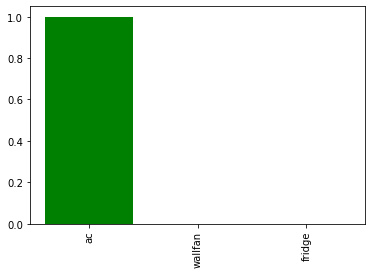

In [251]:
for x in range(58):
    plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=x)

In [313]:
ac = pd.read_csv('ac.csv')
fridge = pd.read_csv('fridge.csv')
d3printer = pd.read_csv('3dprinter.csv')
wallfan = pd.read_csv('wallfan.csv')

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

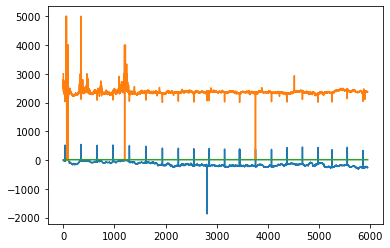

In [352]:
 ac['A1'][:].plot(),ac['AP1'][:].plot(),ac['C1'][:].plot()

<AxesSubplot:>

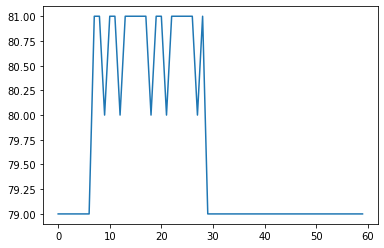

In [324]:
wallfan['A1'][:60].plot()

<AxesSubplot:>

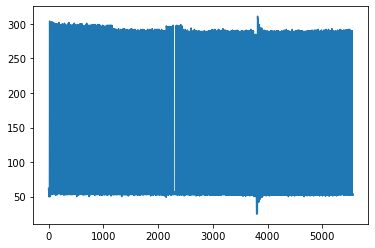

In [325]:
d3printer['A1'].plot()

<AxesSubplot:>

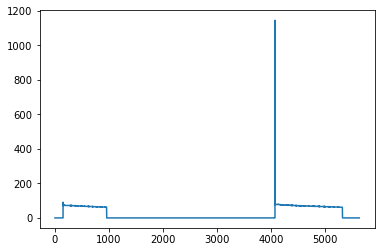

In [326]:
fridge['A1'].plot()